In [1]:
import ijson
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

file_path = 'Data/dblp_v14.json'

# Le chiavi da estrarre
keys_to_extract = ['id', 'title', 'keywords', 'year', 'n_citation', 'abstract', 'authors', 'doc_type', 'references']

# Function to extract and rename fields from authors
def extract_author_fields(authors_list):
    if not authors_list:
        return None, None, None
    author_ids = []
    author_names = []
    author_orgs = []
    for author in authors_list:
        author_ids.append(author.get('id', None))
        author_names.append(author.get('name', None))
        author_orgs.append(author.get('org', None))
    return author_ids, author_names, author_orgs

# Open the JSON file
with open(file_path, 'r') as f:
    # Iterate over objects in the JSON file
    objects = ijson.items(f, 'item')
    
    # Read only the first N objects
    N = 10000
    partial_data = []
    for _, obj in tqdm(zip(range(N), objects), total=N, desc="Processing JSON Data"):
        filtered_obj = {k: obj[k] for k in keys_to_extract if k in obj}
        
        if 'year' in filtered_obj and filtered_obj['year'] >= 2010:
            
            # if 'keywords' in filtered_obj and not filtered_obj['keywords']:
            #     filtered_obj['keywords'] = None
            
            if 'authors' in filtered_obj:
                author_ids, author_names, author_orgs = extract_author_fields(filtered_obj['authors'])
                filtered_obj['author_ids'] = author_ids if author_ids else None
                filtered_obj['author_names'] = author_names if author_names else None
                filtered_obj['author_orgs'] = author_orgs if author_orgs else None
                del filtered_obj['authors']
            
            partial_data.append(filtered_obj)

# Create a DataFrame from partial_data
df = pd.DataFrame(partial_data)

# Example usage of the DataFrame
print(df.shape)
display(df.head())

# Save the DataFrame to a CSV file
# df.to_csv('processed_data.csv', index=False)

Processing JSON Data: 100%|██████████| 1000/1000 [00:00<00:00, 15956.84it/s]

(535, 11)


,id,title,keywords,year,n_citation,abstract,doc_type,author_ids,author_names,author_orgs,references
0,53e99784b7602d9701f3ffdd,Flow.,[],2006,15,,Conference,[53f43776dabfaee0d9b6e75b],[Masa Inakage],[],NaN
1,53e99785b7602d9701f414cb,Drift,[],2004,0,,Conference,[53f433e6dabfaeee229920b6],[Justin Booth-Clibborn],"[New York, New York]",NaN
2,53e99785b7602d9701f427df,Estate,[],2004,0,,Conference,[53f460a7dabfaee4dc83702a],[Greg Daville],"[Hove East Sussex, United Kingdom]",NaN
3,53e99785b7602d9701f4283f,Express,"[famous Japanese story, best friend, Galactic ...",2013,656,The story is a sequel of a famous Japanese sto...,Conference,[53f47148dabfaec09f269c9e],[Kohta Morie],"[Transistor Studio, Japan]",NaN
4,53e99785b7602d9701f43f95,Bookshelf,"[415, 460, P.K., Volume 4: Anticipating Chan...",2004,0,Reviewed: Succeeding with Open Source Quality ...,Journal,"[53f4c61fdabfaee57b77b3cf, 53f388cbdabfae4b34a...","[Terry Bollinger, Mike Barker, Philipp K. Janert]","[, , ]",NaN


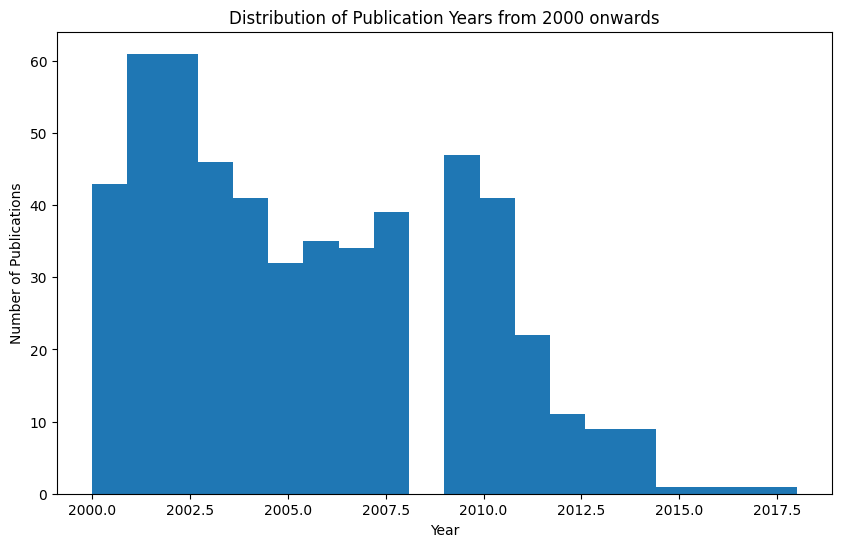

In [2]:
import matplotlib.pyplot as plt

# Create a histogram of the distribution of years
plt.figure(figsize=(10, 6))
df['year'].dropna().astype(int).hist(bins=20)
plt.title('Distribution of Publication Years from 2000 onwards')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.grid(False)
plt.show()

In [3]:
# TODO: unire in un unico campo 'title', 'abstract' e 'keywords'
# TODO: aggiungere info su autori e organizzazioni

from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Load pre-trained BERT model and tokenizer
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(f'Using device: {device}')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Function to get BERT embeddings
def get_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()

# Apply BERT embeddings to 'title', 'abstract', 'keywords'
df['title'] = df['title'].fillna('')
df['abstract'] = df['abstract'].fillna('')
df['keywords'] = df['keywords'].fillna('').apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

print('Computing BERT embeddings for title...')
title_embeddings = np.vstack(df['title'].apply(get_bert_embeddings).values)
print('Computing BERT embeddings for abstract...')
abstract_embeddings = np.vstack(df['abstract'].apply(get_bert_embeddings).values)
print('Computing BERT embeddings for keywords...')
keywords_embeddings = np.vstack(df['keywords'].apply(get_bert_embeddings).values)
print('Done!')

# One-Hot Encoding for 'doc_type'
one_hot_encoder = OneHotEncoder(sparse_output=False)
doc_type_one_hot = one_hot_encoder.fit_transform(df[['doc_type']].fillna(''))

# Normalize 'year' and 'n_citation'
scaler = StandardScaler()
year_scaled = scaler.fit_transform(df[['year']].fillna(2000))  # Assuming a default year of 2000
citation_scaled = scaler.fit_transform(df[['n_citation']].fillna(0))  # Assuming a default citation count of 0

# Combine all features
features = np.hstack((title_embeddings, abstract_embeddings, keywords_embeddings, doc_type_one_hot, year_scaled, citation_scaled))

# Example usage of the DataFrame
print(features.shape)  # Should print the shape of the feature matrix

/Users/andrea/miniforge3/envs/dygnn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps
Computing BERT embeddings for title...
Computing BERT embeddings for abstract...
Computing BERT embeddings for keywords...
Done!
(535, 2308)


In [4]:
doc_type_one_hot

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [6]:
title_embeddings.shape

(535, 768)